Импорт библиотек

In [39]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from itertools import product

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

Привязываем гугл-диск для загрузкии датасетов. Берем один из них для первочного анализа.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
df_microsoft = pd.read_csv('/content/drive/MyDrive/datasets/microsoft.csv')
df_microsoft.head(5)

,Date,Open,High,Low,Close,Volume,Currency
0,2010-01-04,30.62,31.10,30.59,30.95,38414184,USD
1,2010-01-05,30.85,31.10,30.64,30.96,49758864,USD
2,2010-01-06,30.88,31.08,30.52,30.77,58182332,USD
3,2010-01-07,30.63,30.70,30.19,30.45,50564284,USD
4,2010-01-08,30.28,30.88,30.24,30.66,51201288,USD


Берем второй датасет из геймдеав-компании для сравнения.

In [23]:
df_nintendo = pd.read_csv('/content/drive/MyDrive/datasets/nintendo.csv')
df_nintendo.head(5)

,Date,Open,High,Low,Close,Volume,Currency
0,2010-01-04,30.25,30.95,30.25,30.90,105408,USD
1,2010-01-05,31.15,32.50,31.05,31.47,210553,USD
2,2010-01-06,32.90,33.40,31.81,33.15,367749,USD
3,2010-01-07,33.90,34.35,33.90,34.22,416643,USD
4,2010-01-08,34.55,34.85,34.40,34.82,441858,USD


Аналогично смотрим на другие датасеты, чтобы проверить схожсть их формата. Далее мы анализируем один датасет, его признаки, чтобы привести его в формат, пригодный для машинного обучения.

In [24]:
df_microsoft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3191 entries, 0 to 3190
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3191 non-null   object 
 1   Open      3191 non-null   float64
 2   High      3191 non-null   float64
 3   Low       3191 non-null   float64
 4   Close     3191 non-null   float64
 5   Volume    3191 non-null   int64  
 6   Currency  3191 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 174.6+ KB


В датасете нет пропусков. Ничего выполнять не нужно.

In [25]:
df_microsoft.Currency.value_counts()

,count
Currency,
USD,3191


Этот признак можно отбромить, потому что в нем тольео одно значение. Отбрасываем сразу ддля всех датафреймов, всех акций. (Конечно, до этого проверяем, что везде есть только доллары и не затесалась какая-то другая валюта.)

In [26]:
df_microsoft.drop(['Currency'], axis=1).head()

,Date,Open,High,Low,Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,38414184
1,2010-01-05,30.85,31.10,30.64,30.96,49758864
2,2010-01-06,30.88,31.08,30.52,30.77,58182332
3,2010-01-07,30.63,30.70,30.19,30.45,50564284
4,2010-01-08,30.28,30.88,30.24,30.66,51201288


Построю матрицу корреляций, чтобы посмотреть, необходимо ли убрать какие-то признаки.

In [27]:
# df_microsoft.corr()

Вообще здесь везде оень высокие корреляции почти, но ценой на открытии акии и на закрытии она прям очень высокая. Попробуем "слить" их в одну переменную.

Далее есть гипотеза, что можно объединить в один признак фичи open и close и поместить в датафрейм разницу между ними вместо самих этих признаков. То есть будет 1 новая фича вместо двуз старых. При этом это должен быть новый датафрейм для постановки новых гипотез.

In [28]:
#ваш код здесь
df_beta = pd.DataFrame({
    'Date': df_microsoft['Date'],
    'Open-Close': df_microsoft['Close']-df_microsoft['Open'],
    })
df_beta.head(10)

,Date,Open-Close
0,2010-01-04,0.33
1,2010-01-05,0.11
2,2010-01-06,-0.11
3,2010-01-07,-0.18
4,2010-01-08,0.38
5,2010-01-11,-0.44
6,2010-01-12,-0.08
7,2010-01-13,0.09
8,2010-01-14,0.65
9,2010-01-15,-0.22


Далее мы помотрим каждый признак датасета на выбросы при помощи ящичковой диаграммы

Здесь мы видим, что у нас очень много выбросов. Попробем их хотя бы немного подчистить. Давайте уберем все выбросы, которые выше значения 0.6, задав им, например, среднее по фиче. Сначала найдем среднее.

In [29]:
mean = df_microsoft['Volume'].mean()
mean

np.float64(38246878.50015669)

Далее мы зададим каждому выбросу вот это значение среднего, а потом снова построим ящичковую диаграмму.

<Axes: >

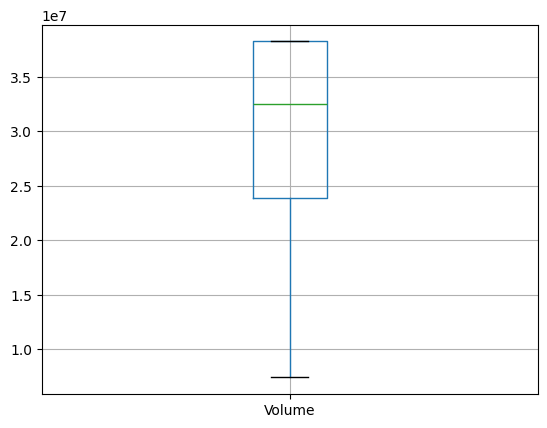

In [30]:
df_beta['Volume'] = [df_microsoft['Volume'][i] if df_microsoft['Volume'][i] <= mean else mean for i in range(df_microsoft.shape[0])]
df_beta.boxplot(column=['Volume'])

In [31]:
def treat_outliers(series, method='iqr', threshold=1.5):
    if method == 'iqr':
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + threshold * iqr
        lower_bound = q1 - threshold * iqr
        return series.clip(lower_bound, upper_bound)
    elif method == 'quantile':
        return series.clip(series.quantile(0.05), series.quantile(0.95))
    else:
        return series

def normalize(data):
    """
    Препроцессинг данных.
    """
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['Date_int'] = data['Date'].astype('int64') // 10**9
    data['Day_of_week'] = data['Date'].dt.dayofweek
    data['Month_end'] = data['Date'].dt.is_month_end.astype(int)
    data['Price_change'] = data['Close'].pct_change()
    #data['Volatility'] = data['Price_change'].rolling(5).std()
    return data.dropna()

def render_plot(i, dates, y_true, y_pred=None, title=""):
    plt.subplot(3, 3, i+1)
    plt.plot(dates, y_true, label='Фактические цены')
    if y_pred is not None:
        plt.plot(dates[-len(y_pred):], y_pred, label='Предсказанные цены')
    plt.grid(linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.legend()

Netflix              MAPE: 0.5889
act_bliz             MAPE: 0.2508
ea                   MAPE: 0.2438
microsoft            MAPE: 0.4234
nintendo             MAPE: 0.2772
take_two             MAPE: 0.2277
tencent              MAPE: 0.3451
ubisoft              MAPE: 0.3335
zynga                MAPE: 0.3129

Average MAPE: 0.3337


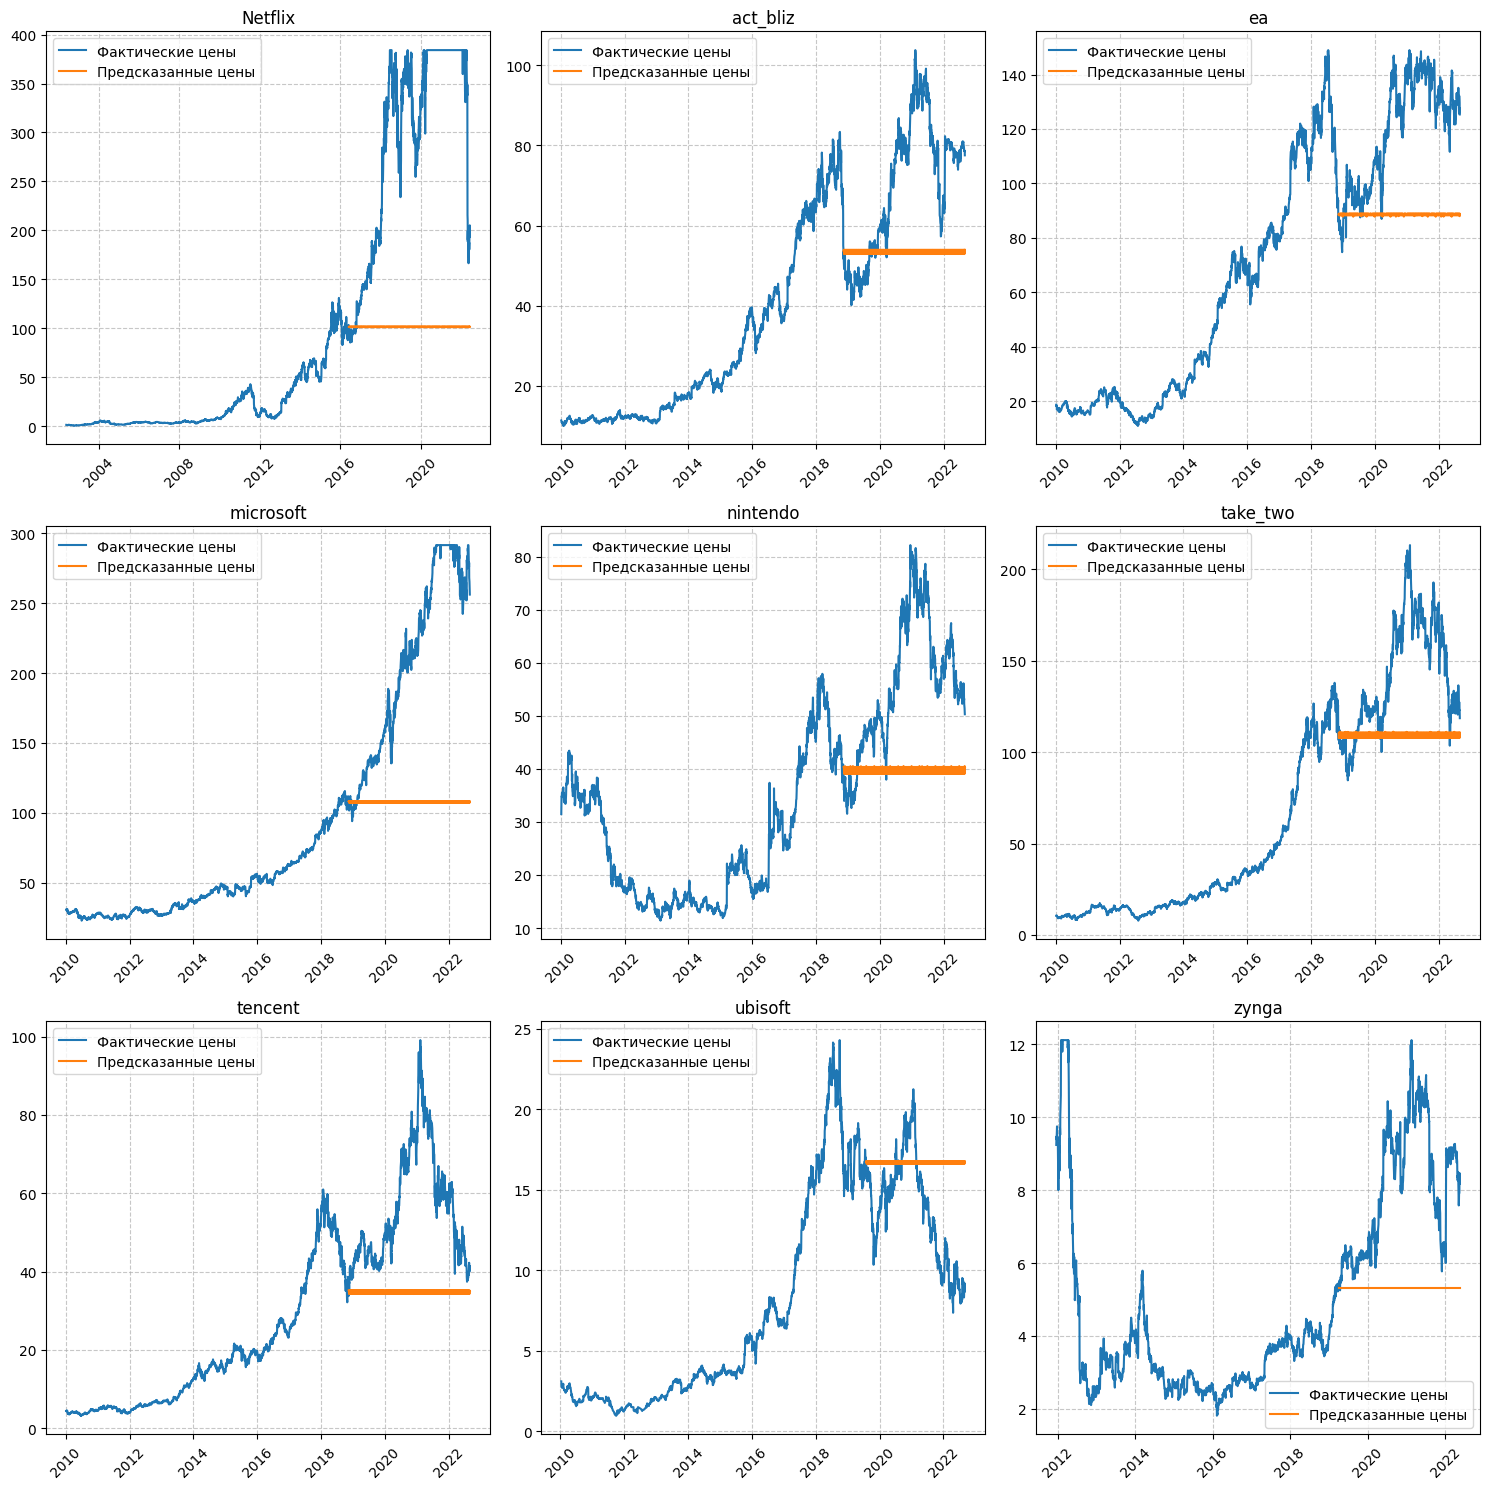

In [43]:
file_paths = sorted(glob('drive/MyDrive/datasets/*.csv'))
metrics = []
plt.figure(figsize=(15, 15))
model = GradientBoostingRegressor(n_estimators=150, random_state=42)

for i, file_path in enumerate(file_paths[:9]):  # Limit to 9 plots
    df = normalize(pd.read_csv(file_path))
    df['Close'] = treat_outliers(df['Close'])

    features = ['Date_int', 'Day_of_week', 'Month_end', 'Year'] #, 'Volatility'
    X = df[features]
    y = df['Close']

    split_idx = int(len(df) * 0.7)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mape = round(mean_absolute_percentage_error(y_test, preds), 4)
    metrics.append(mape)
    print(f"{file_path.split('/')[-1][:-4]:<20} MAPE: {mape}")

    render_plot(i, df['Date'], df['Close'], preds, file_path.split('/')[-1][:-4])

print(f'\nAverage MAPE: {np.mean(metrics):.4f}')
plt.tight_layout()
plt.show()

MAPE: 0.8875
MAPE: 0.1420
MAPE: 0.1017
MAPE: 0.0819
MAPE: 0.2641
MAPE: 0.1963
MAPE: 0.2171
MAPE: 0.5266
MAPE: 0.1796

Average MAPE across all stocks: 0.2885


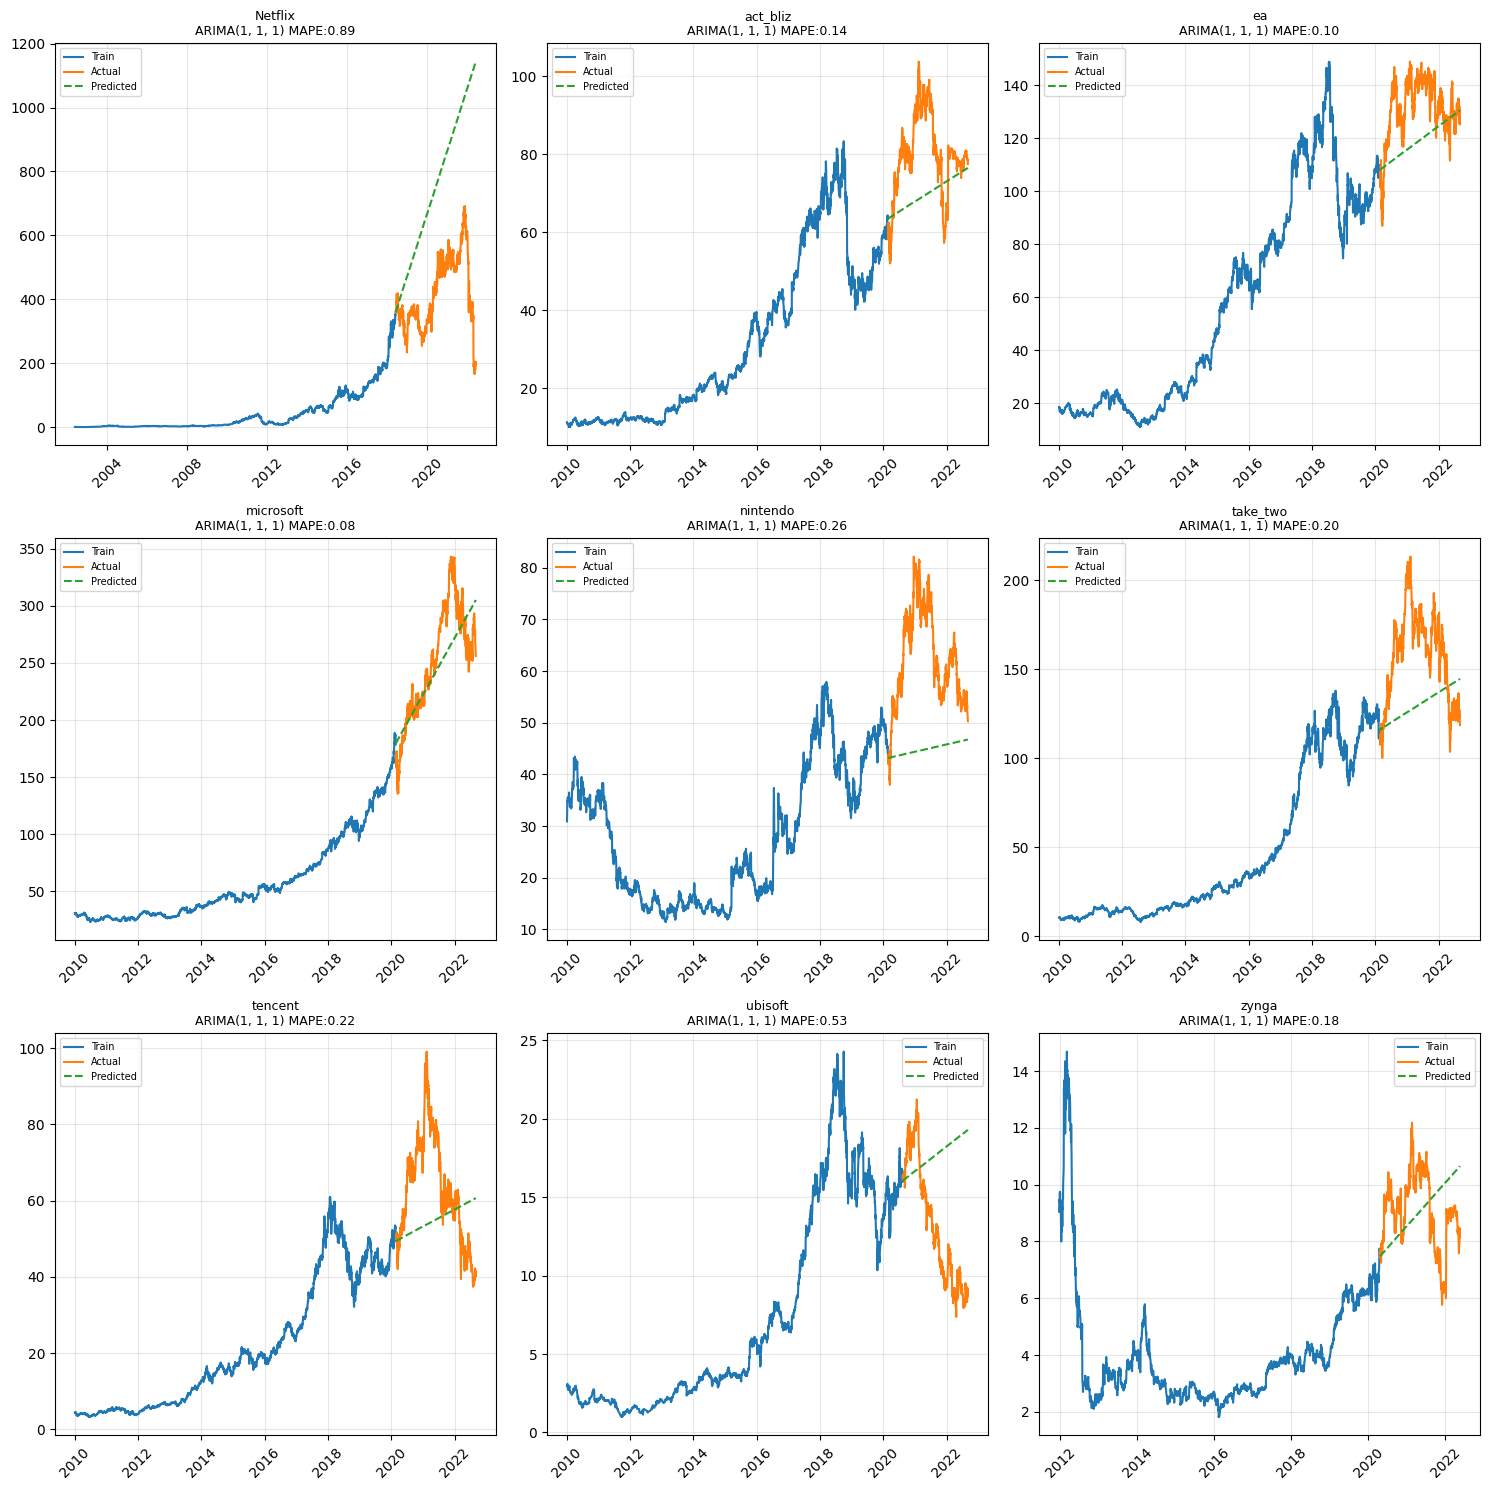

In [46]:
"""
А теперь пробуем ARIMA, которая специально создана для работы с временными рядами.
"""

def prepare_data(df):
    """Prepare time series data for ARIMA"""
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df['Close'].dropna()

def find_best_arima(train_series, max_p=3, max_d=2, max_q=3):
    """Manual grid search for ARIMA parameters"""
    best_aic = np.inf
    best_order = None

    # Test different combinations of p, d, q
    for p, d, q in product(range(max_p+1), range(max_d+1), range(max_q+1)):
        if p == 0 and q == 0:  # Skip ARIMA(0,d,0)
            continue

        try:
            model = ARIMA(train_series, order=(p,d,q))
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p,d,q)
                print(f"New best AIC: {best_aic:.1f} for order {best_order}")

        except:
            continue

    return best_order

def plot_arima_results(i, train, test, preds, title, order):
    """Visualize ARIMA results"""
    plt.subplot(3, 3, i+1)
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, preds, label='Predicted', linestyle='--')
    plt.title(f"{title}\nARIMA{order} MAPE:{mean_absolute_percentage_error(test, preds):.2f}", fontsize=9)
    plt.legend(fontsize=7)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)

# Main execution
file_paths = sorted(glob('drive/MyDrive/datasets/*.csv'))[:9]
metrics = []
plt.figure(figsize=(15, 15))

for i, file_path in enumerate(file_paths):
    # Load and prepare data
    df = pd.read_csv(file_path)
    ts = prepare_data(df)

    # Split data (80% train, 20% test)
    split_idx = int(len(ts) * 0.8)
    train, test = ts[:split_idx], ts[split_idx:]

    # Fit model and forecast
    model = ARIMA(train, order=(2,2,2))
    fitted_model = model.fit()

    # Forecast
    preds = fitted_model.forecast(steps=len(test))

    # Evaluation
    mape = mean_absolute_percentage_error(test, preds)
    metrics.append(mape)
    print(f"MAPE: {mape:.4f}")

    # Plot results
    plot_arima_results(i, train, test, preds,
                        file_path.split('/')[-1][:-4],
                        (1,1,1))

print(f"\nAverage MAPE across all stocks: {np.mean(metrics):.4f}")
plt.tight_layout()
plt.show()